In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm  # Use notebook version for Jupyter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import xgboost as xgb
import random
from datetime import datetime

In [2]:
# Load BDT models
bdt_models = []
for i in range(12):
    filename = f"bdt_model_bg{i+1}_depth2_n100_lr0.1.joblib"
    filepath = os.path.join("models", filename)
    
    if os.path.exists(filepath):
        model = joblib.load(filepath)
        bdt_models.append(model)
        print(f"Loaded BDT Model {i+1} from {filepath}")
    else:
        print(f"Model {i+1} not found, you may need to train it first.")

# Load XGBoost models
xgb_models = []
for i in range(12):
    filename = f"xgb_model_bg{i+1}_depth2_n100_lr0.1.model"
    filepath = os.path.join("xgb_models", filename)
    
    if os.path.exists(filepath):
        model = xgb.Booster()
        model.load_model(filepath)
        xgb_models.append(model)
        print(f"Loaded XGBoost Model {i+1} from {filepath}")
    else:
        print(f"Model {i+1} not found, you may need to train it first.")

Loaded BDT Model 1 from models/bdt_model_bg1_depth2_n100_lr0.1.joblib
Loaded BDT Model 2 from models/bdt_model_bg2_depth2_n100_lr0.1.joblib
Loaded BDT Model 3 from models/bdt_model_bg3_depth2_n100_lr0.1.joblib
Loaded BDT Model 4 from models/bdt_model_bg4_depth2_n100_lr0.1.joblib
Loaded BDT Model 5 from models/bdt_model_bg5_depth2_n100_lr0.1.joblib
Loaded BDT Model 6 from models/bdt_model_bg6_depth2_n100_lr0.1.joblib
Loaded BDT Model 7 from models/bdt_model_bg7_depth2_n100_lr0.1.joblib
Loaded BDT Model 8 from models/bdt_model_bg8_depth2_n100_lr0.1.joblib
Loaded BDT Model 9 from models/bdt_model_bg9_depth2_n100_lr0.1.joblib
Loaded BDT Model 10 from models/bdt_model_bg10_depth2_n100_lr0.1.joblib
Loaded BDT Model 11 from models/bdt_model_bg11_depth2_n100_lr0.1.joblib
Loaded BDT Model 12 from models/bdt_model_bg12_depth2_n100_lr0.1.joblib
Loaded XGBoost Model 1 from xgb_models/xgb_model_bg1_depth2_n100_lr0.1.model
Loaded XGBoost Model 2 from xgb_models/xgb_model_bg2_depth2_n100_lr0.1.model


In [3]:
# Define dataset folder
raw_data_folder = "raw dataset"

# Get all CSV files
all_files = sorted([f for f in os.listdir(raw_data_folder) if f.endswith(".csv")])

# Identify signal and background files
signal_files = [f for f in all_files if "signal" in f.lower()]
background_files = sorted([f for f in all_files if "background" in f.lower() or "b" in f.lower()])

# Ensure files exist
if not signal_files:
    raise FileNotFoundError("No signal file found in the dataset directory.")
if not background_files:
    raise FileNotFoundError("No background files found in the dataset directory.")

# # Load and merge signal datasets
# signal_dfs = [pd.read_csv(os.path.join(raw_data_folder, sf)) for sf in signal_files]
# signal_df = pd.concat(signal_dfs, ignore_index=True)
# signal_df["label"] = 1  # Assign label 1 for signals

# # Load and merge background datasets
# background_dfs = []
background_labels = []

for idx, bg_file in enumerate(background_files):
    # bg_df = pd.read_csv(os.path.join(raw_data_folder, bg_file))
    # bg_df["label"] = 0  # Assign label 0 for backgrounds
    # background_dfs.append(bg_df)
    background_labels.append(bg_file)
    print(f"Loaded Background {idx+1}: {bg_file}")

# Extract feature columns (EXCLUDE "label")
# feature_columns = [col for col in signal_df.columns if col != "label"]

# X_signal = signal_df[feature_columns].copy()
# y_signal = signal_df["label"].copy()

# X_backgrounds = [bg[feature_columns].copy() for bg in background_dfs]
# y_backgrounds = [bg["label"].copy() for bg in background_dfs]

Loaded Background 1: BWW.csv
Loaded Background 2: BZH.csv
Loaded Background 3: BZZ.csv
Loaded Background 4: Bpebb.csv
Loaded Background 5: Bpebbqq.csv
Loaded Background 6: BpeqqH.csv
Loaded Background 7: Bpett.csv
Loaded Background 8: Bqq.csv
Loaded Background 9: BqqHX.csv
Loaded Background 10: BqqX.csv
Loaded Background 11: BqqqqX.csv
Loaded Background 12: Btt.csv


In [4]:
# # Split signal dataset
# X_signal_train, X_signal_test, y_signal_train, y_signal_test = train_test_split(X_signal, y_signal, test_size=0.25, random_state=42)

# # Split each background dataset
# X_backgrounds_train = []
# X_backgrounds_test = []
# y_backgrounds_train = []
# y_backgrounds_test = []

# for X_bg, y_bg in zip(X_backgrounds, y_backgrounds):
#     X_train, X_test, y_train, y_test = train_test_split(X_bg, y_bg, test_size=0.25, random_state=42)
#     X_backgrounds_train.append(X_train)
#     X_backgrounds_test.append(X_test)
#     y_backgrounds_train.append(y_train)
#     y_backgrounds_test.append(y_test)

# Load signal test data
X_val_signal = joblib.load('split_datasets/X_val_signal.pkl')
y_val_signal = joblib.load('split_datasets/y_val_signal.pkl')

# Load background test datasets
X_val_backgrounds = []
y_val_backgrounds = []

for bg_file in background_labels:
    clean_name = bg_file.replace('.csv', '').replace(' ', '_')
    X_val_bg = joblib.load(f'split_datasets/X_val_{clean_name}.pkl')
    y_val_bg = joblib.load(f'split_datasets/y_val_{clean_name}.pkl')
    
    X_val_backgrounds.append(X_val_bg)
    y_val_backgrounds.append(y_val_bg)

# Load signal test data
X_test_signal = joblib.load('split_datasets/X_test_signal.pkl')
y_test_signal = joblib.load('split_datasets/y_test_signal.pkl')

# Load background test datasets
X_test_backgrounds = []
y_test_backgrounds = []

for bg_file in background_labels:
    clean_name = bg_file.replace('.csv', '').replace(' ', '_')
    X_test_bg = joblib.load(f'split_datasets/X_test_{clean_name}.pkl')
    y_test_bg = joblib.load(f'split_datasets/y_test_{clean_name}.pkl')
    
    X_test_backgrounds.append(X_test_bg)
    y_test_backgrounds.append(y_test_bg)

In [6]:
# Initialize storage for NN datasets
X_nn_bdt_train, X_nn_xgb_train = [], []
y_nn_train = []

# Function to extract model outputs
def get_model_outputs(models, dataset_X):
    outputs = []
    for model in models:
        if isinstance(model, xgb.Booster):  # XGBoost models
            dmatrix = xgb.DMatrix(dataset_X)
            outputs.append(model.predict(dmatrix))  # Direct prediction for XGBoost
        else:  # BDT models (Scikit-Learn)
            outputs.append(model.predict_proba(dataset_X)[:, 1])  # Probability of being signal
    return outputs

# Apply models to validation datasets (for NN training)
for dataset_idx, (X_val, y_val) in enumerate(
    zip([X_val_signal] + X_val_backgrounds, [y_val_signal] + y_val_backgrounds)
):
    # Extract BDT and XGB outputs separately
    bdt_train_features = np.column_stack(get_model_outputs(bdt_models, X_val))
    xgb_train_features = np.column_stack(get_model_outputs(xgb_models, X_val))

    # Store separately
    X_nn_bdt_train.append(bdt_train_features)
    X_nn_xgb_train.append(xgb_train_features)
    y_nn_train.append(y_val.to_numpy())
    

# Convert lists to single NumPy arrays
X_nn_bdt_train = np.vstack(X_nn_bdt_train)
X_nn_xgb_train = np.vstack(X_nn_xgb_train)
y_nn_train = np.concatenate(y_nn_train)



# Initialize storage for NN test datasets
X_nn_bdt_test, X_nn_xgb_test = [], []
y_nn_test = []

# Apply models to test datasets (for finding optimal threshold)
for dataset_idx, (X_test, y_test) in enumerate(
    zip([X_test_signal] + X_test_backgrounds, [y_test_signal] + y_test_backgrounds)
):
    # Extract BDT and XGB outputs separately
    bdt_test_features = np.column_stack(get_model_outputs(bdt_models, X_test))
    xgb_test_features = np.column_stack(get_model_outputs(xgb_models, X_test))

    # Store separately
    X_nn_bdt_test.append(bdt_test_features)
    X_nn_xgb_test.append(xgb_test_features)
    y_nn_test.append(y_test.to_numpy())

# Convert lists to single NumPy arrays
X_nn_bdt_test = np.vstack(X_nn_bdt_test)
X_nn_xgb_test = np.vstack(X_nn_xgb_test)
y_nn_test = np.concatenate(y_nn_test)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Training NN_BDT...
Epoch 1/30, Average Loss: 0.3679
Epoch 2/30, Average Loss: 0.3295
Epoch 3/30, Average Loss: 0.3218
Epoch 4/30, Average Loss: 0.3189
Epoch 5/30, Average Loss: 0.3158
Epoch 6/30, Average Loss: 0.3136
Epoch 7/30, Average Loss: 0.3131
Epoch 8/30, Average Loss: 0.3121
Epoch 9/30, Average Loss: 0.3123
Epoch 10/30, Average Loss: 0.3116
Epoch 11/30, Average Loss: 0.3109
Epoch 12/30, Average Loss: 0.3103
Epoch 13/30, Average Loss: 0.3103
Epoch 14/30, Average Loss: 0.3102
Epoch 15/30, Average Loss: 0.3093
Epoch 16/30, Average Loss: 0.3095
Epoch 17/30, Average Loss: 0.3090
Epoch 18/30, Average Loss: 0.3085
Epoch 19/30, Average Loss: 0.3088
Epoch 20/30, Average Loss: 0.3087
Epoch 21/30, Average Loss: 0.3085
Epoch 22/30, Average Loss: 0.3081
Epoch 23/30, Average Loss: 0.3077
Epoch 24/30, Average Loss: 0.3079
Epoch 25/30, Average Loss: 0.3077
Epoch 26/30, Average Loss: 0.3075
Epoch 27/30, Average Loss: 0.3074
Epoch 28/30, Average Loss: 0.3072
Epoch 29/30, Average Loss: 0.3069
Epoc

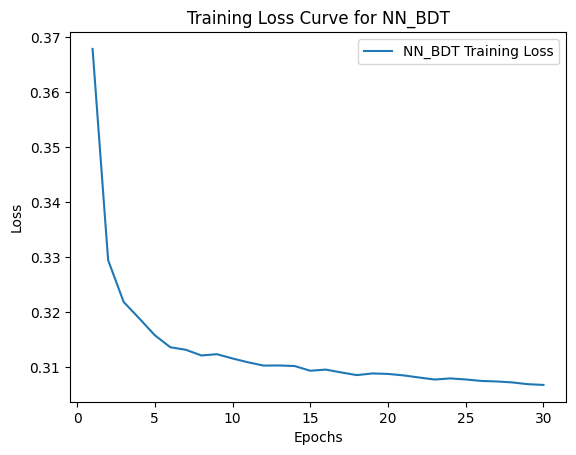

Epoch 1/30, Average Loss: 0.3274
Epoch 2/30, Average Loss: 0.2994
Epoch 3/30, Average Loss: 0.2930
Epoch 4/30, Average Loss: 0.2902
Epoch 5/30, Average Loss: 0.2889
Epoch 6/30, Average Loss: 0.2883
Epoch 7/30, Average Loss: 0.2877
Epoch 8/30, Average Loss: 0.2873
Epoch 9/30, Average Loss: 0.2872
Epoch 10/30, Average Loss: 0.2863
Epoch 11/30, Average Loss: 0.2861
Epoch 12/30, Average Loss: 0.2860
Epoch 13/30, Average Loss: 0.2858
Epoch 14/30, Average Loss: 0.2856
Epoch 15/30, Average Loss: 0.2853
Epoch 16/30, Average Loss: 0.2852
Epoch 17/30, Average Loss: 0.2850
Epoch 18/30, Average Loss: 0.2849
Epoch 19/30, Average Loss: 0.2847
Epoch 20/30, Average Loss: 0.2842
Epoch 21/30, Average Loss: 0.2842
Epoch 22/30, Average Loss: 0.2842
Epoch 23/30, Average Loss: 0.2839
Epoch 24/30, Average Loss: 0.2839
Epoch 25/30, Average Loss: 0.2841
Epoch 26/30, Average Loss: 0.2840
Epoch 27/30, Average Loss: 0.2838
Epoch 28/30, Average Loss: 0.2835
Epoch 29/30, Average Loss: 0.2834
Epoch 30/30, Average Lo

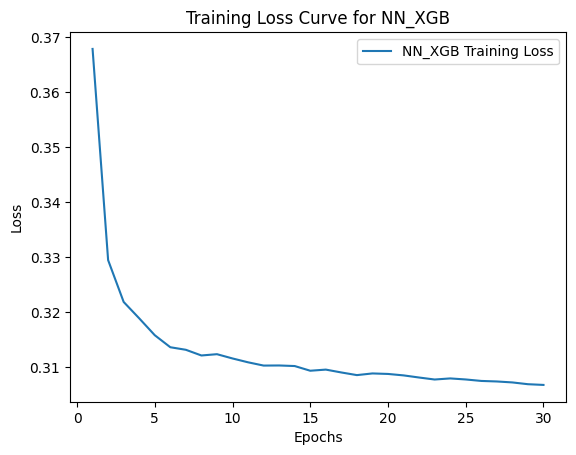

In [8]:
# Convert to PyTorch tensors
X_bdt_train_tensor = torch.tensor(X_nn_bdt_train, dtype=torch.float32)
X_xgb_train_tensor = torch.tensor(X_nn_xgb_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_nn_train, dtype=torch.float32).view(-1, 1)

X_bdt_test_tensor = torch.tensor(X_nn_bdt_test, dtype=torch.float32)
X_xgb_test_tensor = torch.tensor(X_nn_xgb_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_nn_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
bdt_train_loader = DataLoader(TensorDataset(X_bdt_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
xgb_train_loader = DataLoader(TensorDataset(X_xgb_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# Define a simple NN model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize models
nn_bdt = SimpleNN(12)  # 12 BDT features
nn_xgb = SimpleNN(12)  # 12 XGB features

criterion = nn.BCELoss()
optimizer_bdt = optim.Adam(nn_bdt.parameters(), lr=0.001)
optimizer_xgb = optim.Adam(nn_xgb.parameters(), lr=0.001)

loss_history_bdt = []
loss_history_xgb = []

# Train NN_BDT and track loss
print("Training NN_BDT...")
for epoch in range(30):
    total_loss = 0
    num_batches = 0
    
    for batch_X, batch_y in bdt_train_loader:
        optimizer_bdt.zero_grad()
        outputs = nn_bdt(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_bdt.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    loss_history_bdt.append(avg_loss)
    print(f"Epoch {epoch+1}/30, Average Loss: {avg_loss:.4f}")

# Plot loss curve
plt.plot(range(1, 31), loss_history_bdt, label="NN_BDT Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve for NN_BDT")
plt.legend()
plt.show()

# Train NN_XGB
for epoch in range(30):
    total_loss = 0
    num_batches = 0
    
    for batch_X, batch_y in xgb_train_loader:
        optimizer_xgb.zero_grad()
        outputs = nn_xgb(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_xgb.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    loss_history_xgb.append(avg_loss)
    print(f"Epoch {epoch+1}/30, Average Loss: {avg_loss:.4f}")

# Plot loss curve
plt.plot(range(1, 31), loss_history_bdt, label="NN_XGB Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve for NN_XGB")
plt.legend()
plt.show()


In [9]:
# Define weights for each background type
background_weights = {
    "HH": 0.0015552 * 1.155,
    "qq": 0.0349,
    "tt": 0.503,
    "ZZ": 0.17088 * 1.155,
    "WW": 0.5149,
    "qqX": 0.04347826,
    "qqqqX": 0.04,
    "qqHX": 0.001,
    "ZH": 0.00207445 * 1.155,
    "pebb": 0.7536,
    "pebbqq": 0.1522,
    "peqqH": 0.1237,
    "pett": 0.0570,
}

# Apply reweighting factor for the test set
test_size = 0.25
reweight_factor = 1 / test_size  # = 4.0
background_weights = {k: v * reweight_factor for k, v in background_weights.items()}

# Load background types for test set
background_types_test = joblib.load('split_datasets/background_types_test.pkl')

In [10]:
# Get predictions
nn_bdt_output = nn_bdt(X_bdt_test_tensor).detach().numpy().flatten()
nn_xgb_output = nn_xgb(X_xgb_test_tensor).detach().numpy().flatten()

In [11]:
print(len(nn_bdt_output))
print(len(y_nn_test))
print(y_nn_test)
print(sum(y_nn_test))
print(len(background_types_test))

257707
257707
[1 1 1 ... 0 0 0]
57630
200077


In [12]:
def compute_significance(threshold, predictions, true_labels, background_types):
    # Calculate signal count
    signal_count = 0
    signal_weight = background_weights.get("HH")
    
    for i in range(len(predictions)):
        if predictions[i] >= threshold and true_labels[i] == 1:
            signal_count += 1
    
    weighted_signal = signal_count * signal_weight
    # print(f"Signal count: {signal_count}, weighted: {weighted_signal}")
    
    # Calculate background count with weights
    background_count = 0
    background_sum = 0

    j = -1
    for i in range(len(predictions)):
        if true_labels[i] == 0:
            j += 1
            if predictions[i] >= threshold:
                background_count += 1
                bg_type = background_types[j]
                background_sum += background_weights.get(bg_type)

    # Calculate significance
    if weighted_signal + background_sum > 0:
        significance = weighted_signal / np.sqrt(weighted_signal + background_sum)
    else:
        significance = 0
        
    # print(f"Threshold: {threshold}, Significance: {significance}")
    return significance

def compute_asimov_significance(threshold, predictions, true_labels):
    S = np.sum((predictions >= threshold) & (true_labels == 1))
    B = np.sum((predictions >= threshold) & (true_labels == 0))
    
    if B == 0:
        return np.sqrt(2 * S)  # Asimov approximation when B = 0
    
    return np.sqrt(2 * (S + B * np.log(1 + S / B) - B))

# Sweep through cutoffs
thresholds = np.linspace(0.01, 0.99, 99)

best_threshold_bdt, best_threshold_xgb = 0, 0
best_significance_bdt, best_significance_xgb = 0, 0

# best_asimov_threshold_bdt, best_asimov_threshold_xgb = 0, 0
# best_asimov_significance_bdt, best_asimov_significance_xgb = 0, 0

for threshold in thresholds:
    # BDT model
    significance_bdt = compute_significance(threshold, nn_bdt_output, y_nn_test, background_types_test)
    # asimov_significance_bdt = compute_asimov_significance(threshold, nn_bdt_output, y_nn_test)
    
    if significance_bdt > best_significance_bdt:
        best_significance_bdt = significance_bdt
        best_threshold_bdt = threshold

    # if asimov_significance_bdt > best_asimov_significance_bdt:
    #     best_asimov_significance_bdt = asimov_significance_bdt
    #     best_asimov_threshold_bdt = threshold

    # XGB model
    significance_xgb = compute_significance(threshold, nn_xgb_output, y_nn_test, background_types_test)
    # asimov_significance_xgb = compute_asimov_significance(threshold, nn_xgb_output, y_nn_test)
    
    if significance_xgb > best_significance_xgb:
        best_significance_xgb = significance_xgb
        best_threshold_xgb = threshold

    # if asimov_significance_xgb > best_asimov_significance_xgb:
    #     best_asimov_significance_xgb = asimov_significance_xgb
    #     best_asimov_threshold_xgb = threshold

print(f"NN_BDT: Best Threshold = {best_threshold_bdt:.2f}, Max Significance = {best_significance_bdt:.2f}")
print(f"NN_XGB: Best Threshold = {best_threshold_xgb:.2f}, Max Significance = {best_significance_xgb:.2f}")

# print(f"NN_BDT: Best Threshold (Asimov) = {best_asimov_threshold_bdt:.2f}, Max Significance = {best_asimov_significance_bdt:.2f}")
# print(f"NN_XGB: Best Threshold (Asimov) = {best_asimov_threshold_xgb:.2f}, Max Significance = {best_asimov_significance_xgb:.2f}")

NN_BDT: Best Threshold = 0.89, Max Significance = 7.87
NN_XGB: Best Threshold = 0.90, Max Significance = 8.08


In [14]:
# Get training set performance
train_preds_bdt = nn_bdt(X_bdt_train_tensor).detach().numpy().flatten()
train_preds_xgb = nn_xgb(X_xgb_train_tensor).detach().numpy().flatten()

train_acc_bdt = np.mean((train_preds_bdt > 0.5) == y_nn_train)
train_acc_xgb = np.mean((train_preds_xgb > 0.5) == y_nn_train)

test_acc_bdt = np.mean((nn_bdt_output > 0.5) == y_nn_test)
test_acc_xgb = np.mean((nn_xgb_output > 0.5) == y_nn_test)

print(f"NN_BDT Train Accuracy: {train_acc_bdt:.4f}, Test Accuracy: {test_acc_bdt:.4f}")
print(f"NN_XGB Train Accuracy: {train_acc_xgb:.4f}, Test Accuracy: {test_acc_xgb:.4f}")


NN_BDT Train Accuracy: 0.8679, Test Accuracy: 0.8671
NN_XGB Train Accuracy: 0.8766, Test Accuracy: 0.8762


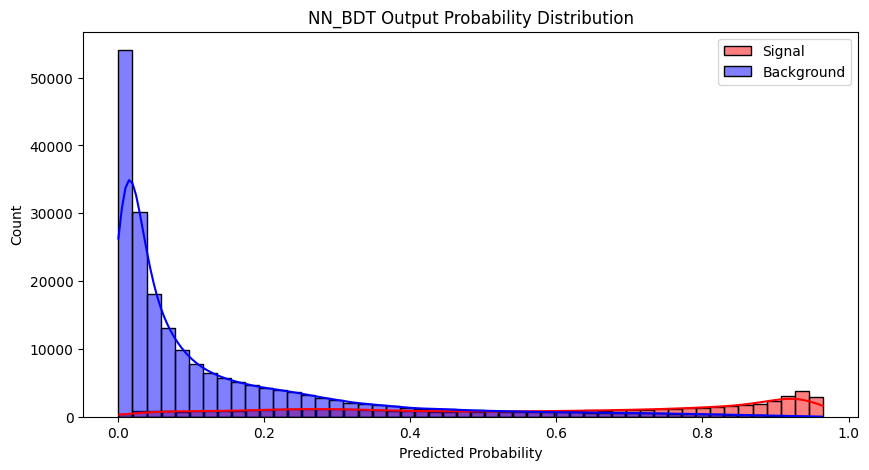

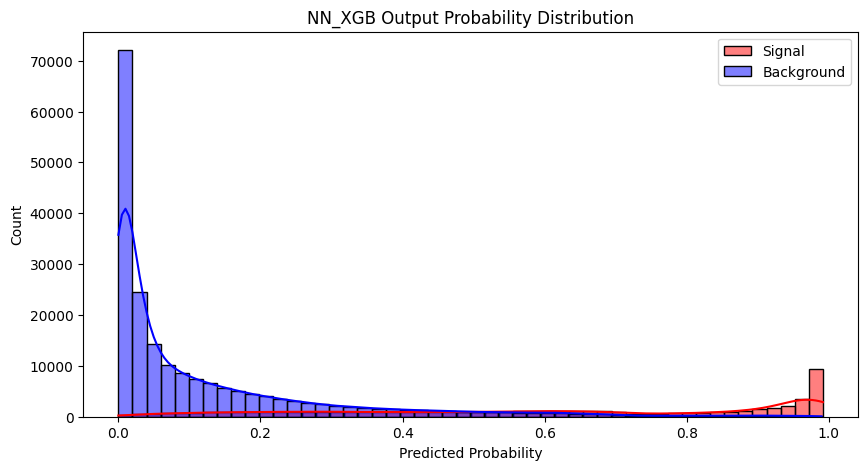

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of NN outputs for signal and background
plt.figure(figsize=(10,5))
sns.histplot(nn_bdt_output[y_nn_test == 1], bins=50, color='red', label="Signal", kde=True)
sns.histplot(nn_bdt_output[y_nn_test == 0], bins=50, color='blue', label="Background", kde=True)
plt.title("NN_BDT Output Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Plot distribution of NN outputs for signal and background
plt.figure(figsize=(10,5))
sns.histplot(nn_xgb_output[y_nn_test == 1], bins=50, color='red', label="Signal", kde=True)
sns.histplot(nn_xgb_output[y_nn_test == 0], bins=50, color='blue', label="Background", kde=True)
plt.title("NN_XGB Output Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


In [26]:
# libraries for genetic algorithm
from deap import base, creator, tools, algorithms
from sklearn.metrics import log_loss
from scipy.special import expit  # Sigmoid function

In [ ]:
# Define optimization problem: Minimize Binary Cross-Entropy Loss
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Function to create an individual (12 weights instead of 1)
def create_individual():
    return creator.Individual([random.uniform(0, 2) for _ in range(12)])  # 12 weights

# Fitness function for evaluating weight vectors
def evaluate(individual, predictions, labels):
    weights = np.array(individual)  # Convert to NumPy array (12 values)
    
    # Apply weights to the 12-dimensional feature vector (element-wise multiplication)
    weighted_preds = np.sum(weights * predictions, axis=1)  # Sum weighted features
    
    # Compute Binary Cross-Entropy Loss
    loss = log_loss(labels, weighted_preds)
    return (loss,)

# Function to create GA toolbox
def create_ga_toolbox(predictions, labels):
    toolbox = base.Toolbox()
    toolbox.register("individual", create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate, predictions=predictions, labels=labels)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)  # Mutation
    toolbox.register("select", tools.selTournament, tournsize=3)  # Selection
    return toolbox

# Train GA separately for BDT (12 weights)
toolbox_bdt = create_ga_toolbox(X_nn_bdt_train, y_nn_train)
pop_bdt = toolbox_bdt.population(n=50)

# Train GA separately for XGB (12 weights)
toolbox_xgb = create_ga_toolbox(X_nn_xgb_train, y_nn_train)
pop_xgb = toolbox_xgb.population(n=50)

# Train the GA function
def train_ga(toolbox, pop, ngen=30, cxpb=0.5, mutpb=0.2):
    hof = tools.HallOfFame(1)  # Store the best individual
    algorithms.eaSimple(pop, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=hof, verbose=True)
    return hof[0]  # Return best individual

# Run GA training for BDT and XGB
best_w_bdt = train_ga(toolbox_bdt, pop_bdt)
best_w_xgb = train_ga(toolbox_xgb, pop_xgb)

# Extract best weights (12 values each)
w_bdt = np.array(best_w_bdt)
w_xgb = np.array(best_w_xgb)

# Apply optimized 12-dimensional weights to test set
y_pred_bdt = np.sum(w_bdt * X_nn_bdt_test, axis=1)
y_pred_xgb = np.sum(w_xgb * X_nn_xgb_test, axis=1)

# Evaluate test performance
loss_bdt = log_loss(y_nn_test, y_pred_bdt)
loss_xgb = log_loss(y_nn_test, y_pred_xgb)

print(f"Optimized 12-Dimensional Weights for BDT: {w_bdt}, Test Loss: {loss_bdt}")
print(f"Optimized 12-Dimensional Weights for XGB: {w_xgb}, Test Loss: {loss_xgb}")

/Users/yagishinnosuke/Documents/2024-2025 Stanford/CS229/Final Project/myenv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/yagishinnosuke/Documents/2024-2025 Stanford/CS229/Final Project/myenv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	34    
2  	31    
3  	23    
4  	28    
5  	28    
6  	27    
7  	30    
8  	21    
9  	23    
10 	32    
11 	34    
12 	29    
13 	22    
14 	31    
15 	29    
16 	35    
17 	30    
18 	32    
19 	26    
20 	30    
21 	30    
22 	30    
23 	34    
24 	31    
25 	25    
26 	37    
27 	34    
28 	29    
29 	26    
30 	34    
gen	nevals
0  	50    
1  	24    
2  	25    
3  	31    
4  	30    
5  	32    
6  	23    
7  	24    
8  	26    
9  	25    
10 	29    
11 	30    
12 	33    
13 	33    
14 	26    
15 	35    
16 	29    
17 	31    
18 	30    
19 	32    
20 	36    
21 	28    
22 	26    
23 	33    
24 	26    
25 	31    
26 	24    
27 	38    
28 	38    
29 	33    
30 	21    
Optimized 12-Dimensional Weights for BDT: [ 0.08478835 -0.31304281  0.58952082  0.77356228  0.02710953  0.09704287
  0.60922223  0.30380956  0.15680271  0.54560095 -0.77078709 -1.41018656], Test Loss: 0.714403586886504
Optimized 12-Dimensional Weights for XGB: [-0.74036898 -0.7120982   1.4163286

In [27]:
# Apply sigmoid and scale to range (-1, 1)
y_pred_bdt = 2 * expit(y_pred_bdt) - 1
y_pred_xgb = 2 * expit(y_pred_xgb) - 1

In [29]:
# Sweep through cutoffs
thresholds = np.linspace(-2, 1.5, 50)

best_threshold_bdt_ga, best_threshold_xgb_ga = 0, 0
best_significance_bdt_ga, best_significance_xgb_ga = 0, 0

# best_asimov_threshold_bdt, best_asimov_threshold_xgb = 0, 0
# best_asimov_significance_bdt, best_asimov_significance_xgb = 0, 0

for threshold in thresholds:
    # BDT model
    significance_bdt_ga = compute_significance(threshold, y_pred_bdt, y_nn_test, background_types_test)
    # asimov_significance_bdt = compute_asimov_significance(threshold, nn_bdt_output, y_nn_test)
    
    if significance_bdt_ga > best_significance_bdt_ga:
        best_significance_bdt_ga = significance_bdt_ga
        best_threshold_bdt_ga = threshold

    # if asimov_significance_bdt > best_asimov_significance_bdt:
    #     best_asimov_significance_bdt = asimov_significance_bdt
    #     best_asimov_threshold_bdt = threshold

    # XGB model
    significance_xgb_ga = compute_significance(threshold, y_pred_xgb, y_nn_test, background_types_test)
    # asimov_significance_xgb = compute_asimov_significance(threshold, nn_xgb_output, y_nn_test)
    
    if significance_xgb_ga > best_significance_xgb_ga:
        best_significance_xgb_ga = significance_xgb_ga
        best_threshold_xgb_ga = threshold

    # if asimov_significance_xgb > best_asimov_significance_xgb:
    #     best_asimov_significance_xgb = asimov_significance_xgb
    #     best_asimov_threshold_xgb = threshold

print(f"GA_BDT: Best Threshold = {best_threshold_bdt_ga:.2f}, Max Significance = {best_significance_bdt_ga:.2f}")
print(f"GA_XGB: Best Threshold = {best_threshold_xgb_ga:.2f}, Max Significance = {best_significance_xgb_ga:.2f}")

# print(f"NN_BDT: Best Threshold (Asimov) = {best_asimov_threshold_bdt:.2f}, Max Significance = {best_asimov_significance_bdt:.2f}")
# print(f"NN_XGB: Best Threshold (Asimov) = {best_asimov_threshold_xgb:.2f}, Max Significance = {best_asimov_significance_xgb:.2f}")

GA_BDT: Best Threshold = 0.21, Max Significance = 3.17
GA_XGB: Best Threshold = 0.14, Max Significance = 3.42


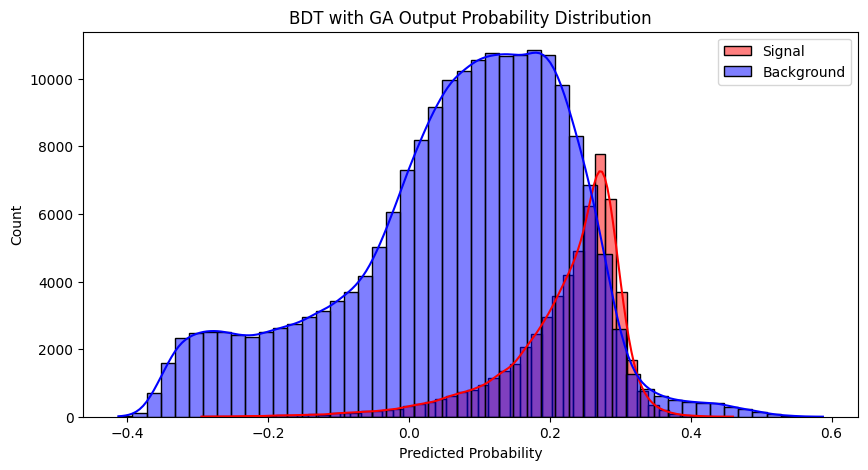

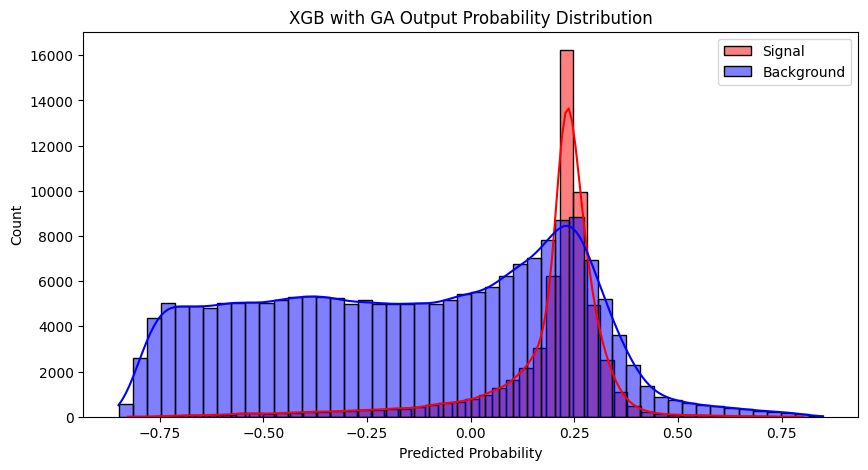

In [30]:
# Plot distribution of NN outputs for signal and background
plt.figure(figsize=(10,5))
sns.histplot(y_pred_bdt[y_nn_test == 1], bins=50, color='red', label="Signal", kde=True)
sns.histplot(y_pred_bdt[y_nn_test == 0], bins=50, color='blue', label="Background", kde=True)
plt.title("BDT with GA Output Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Plot distribution of NN outputs for signal and background
plt.figure(figsize=(10,5))
sns.histplot(y_pred_xgb[y_nn_test == 1], bins=50, color='red', label="Signal", kde=True)
sns.histplot(y_pred_xgb[y_nn_test == 0], bins=50, color='blue', label="Background", kde=True)
plt.title("XGB with GA Output Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()